In [23]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFwe, f_regression
import warnings

In [9]:
# as there are many warning from MLP conversion and some from setticklabels we want to disable them for a smoother reading flow
warnings.filterwarnings("ignore")

In [10]:
# load the dataset
raw_data_red = pd.read_csv("winequality-red.csv", delimiter=';')

# show the created dataframe for red and white wine
display(raw_data_red.head())

# print the shape of the newly formed dataframe
raw_data_red.shape

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


(1599, 12)

In this code block, we conduct a thorough examination of the 'quality' variable (target label) in the dataset. Beginning with a detailed histogram showcasing the distribution of quality levels, we proceed to reveal the counts associated with each rating. Finally, a statistical overview using .describe() provides key summary statistics, enhancing our understanding of the dataset's central tendencies and variations. These visualizations and analyses serve as foundational steps for subsequent data exploration and decision-making (f.e. Balancing).

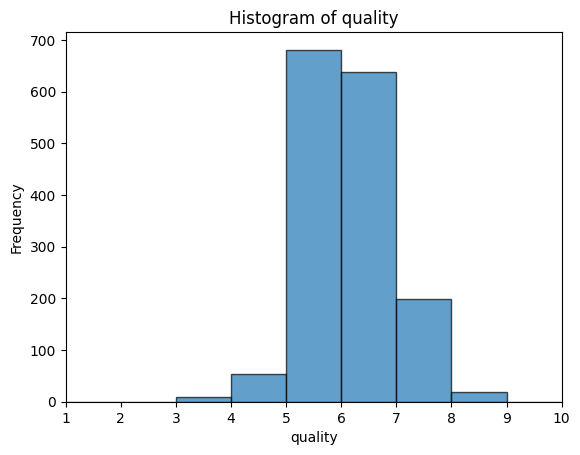

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [6]:
plt.hist(raw_data_red['quality'], bins=range(0, 12), edgecolor='k', alpha=0.7)
plt.xlabel('quality')
plt.ylabel('Frequency')
plt.title('Histogram of quality')
plt.xlim(1, 10)
plt.show()

# show the number of entries for each value
value_counts = raw_data_red['quality'].value_counts()
print(value_counts)
raw_data_red.describe()

The observed distribution of wine quality in the dataset exhibits potential issues related to class imbalance, particularly with lower and higher quality ratings being underrepresented. This imbalance could impact the performance and reliability of predictive models. Furthermore, the absence of certain quality levels (1, 2, 10) prompts consideration of strategies for handling missing or unobserved data, influencing the choice between extrapolation and interpolation approaches in regression modeling. Addressing these issues is crucial for ensuring the robustness and generalizability of subsequent analyses and predictive modeling in the wine quality assessment.

Moving forward, we will examine missing data to implement strategies for handling any gaps in the dataset, enhancing the overall reliability of our subsequent analyses and machine learning models.

In [6]:
# check for missing data
missing_data = raw_data_red.isnull().sum()
print("Missing Data:")
missing_data

Missing Data:


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

No missing data has been identified, eliminating the necessity for additional actions in this regard.

Transitioning to outlier analysis, we will now visually examine the data using boxplots. Outliers, indicative of extreme values, can be identified in these plots as data points that fall significantly beyond the whiskers of the box-and-whisker diagram, providing insights into potential anomalies or irregularities in the dataset.

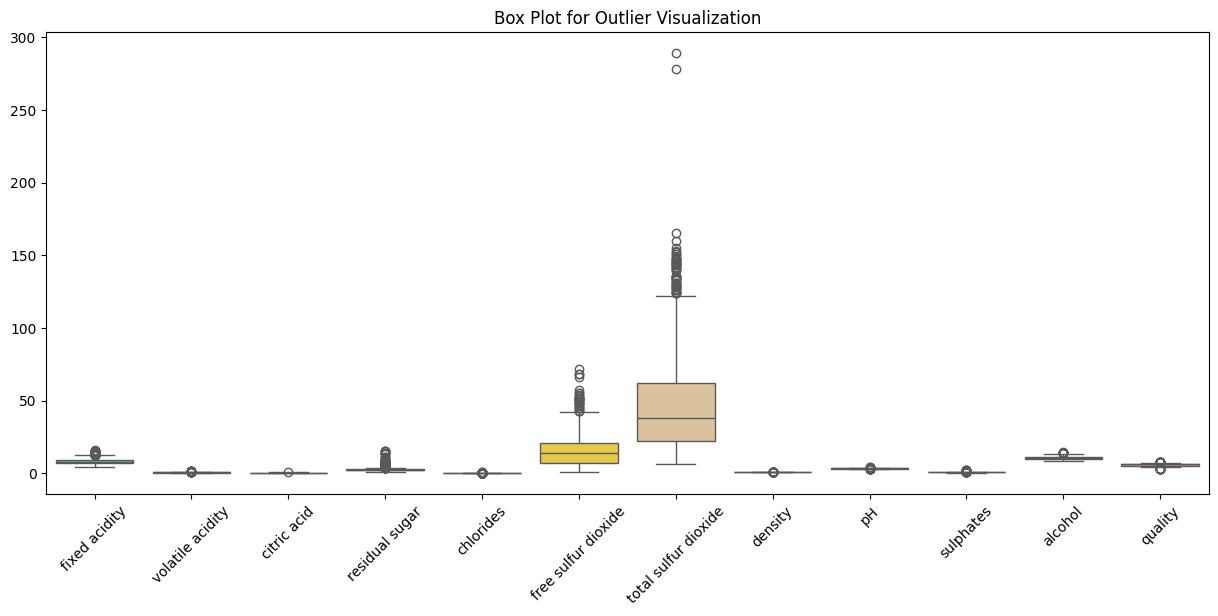

In [11]:
# detect and visualize outliers
plt.figure(figsize=(15, 6))
box_plot = sns.boxplot(data=raw_data_red, palette='Set2')
plt.title("Box Plot for Outlier Visualization")
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45)
plt.show()

Upon inspecting the boxplots, it is evident that features such as total sulfur dioxide exhibit a broad range of values, with notable variability. Additionally, discernible outliers, characterized by substantial distances of data points from the whiskers, are observed in features total and free sulfur dioxide. This variance and the presence of outliers suggest potential areas of interest or concern in the dataset.

Continuing with the analysis, we will employ both the Interquartile Range (IQR) and z-Score transformation metrics to systematically identify outliers. We have chosen a threshold of four for both methods. This decision is based on a balance between sensitivity and specificity, aiming to capture significant deviations from the norm without excessively flagging data points as outliers.

In [34]:
# detect outliers based on mathematical functions

# select numerical columns for outlier detection
numerical_columns = raw_data_red.select_dtypes(include=[np.number])

# Set a threshold
threshold = 4.0

# IQR-based

# define the IQR-based outlier detection function
def detect_outliers_iqr(series, threshold=threshold):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return (series < lower_bound) | (series > upper_bound)

# exclude the string attribute from the outlier detection and perform calculation
iqr_outlier_mask = numerical_columns.apply(detect_outliers_iqr)

# count the number of rows with outliers
iqr_outlier_count = iqr_outlier_mask.any(axis=1).sum()

# calculate the percentage of rows with outliers
iqr_outlier_percentage = (iqr_outlier_count / len(raw_data_red)) * 100

# display the count and percentage
print(f'There are {iqr_outlier_count} rows with outliers when using the IQR with a threshold of {threshold}.')
print(f'This represents {iqr_outlier_percentage:.2f}% of all rows.')

# Z-Score-based

# Calculate z-scores for each numerical column
z_scores = np.abs(zscore(numerical_columns))

# Create a mask for outliers
z_outlier_mask = (z_scores > threshold).any(axis=1)

# Count the number of rows with outliers
z_outlier_count = np.sum(z_outlier_mask)

# calculate the percentage of rows with outliers
z_outlier_percentage = (z_outlier_count / len(raw_data_red)) * 100

# Display the count and percentage only once if there are outliers
print(f'There are {z_outlier_count} rows with outliers when using Z-Score with a threshold of {threshold}.')
print(f'This represents {z_outlier_percentage:.2f}% of all rows.')

There are 127 rows with outliers when using the IQR with a threshold of 4.0.
This represents 7.94% of all rows.
There are 62 rows with outliers when using Z-Score with a threshold of 4.0.
This represents 3.88% of all rows.


Having obtained the counts of outliers, it is crucial to delve deeper into the 'quality' feature to discern which quality levels are impacted by these outliers. This closer examination will provide insights into the specific qualities affected by the identified outliers, facilitating a more targeted understanding of their potential impact on the dataset.

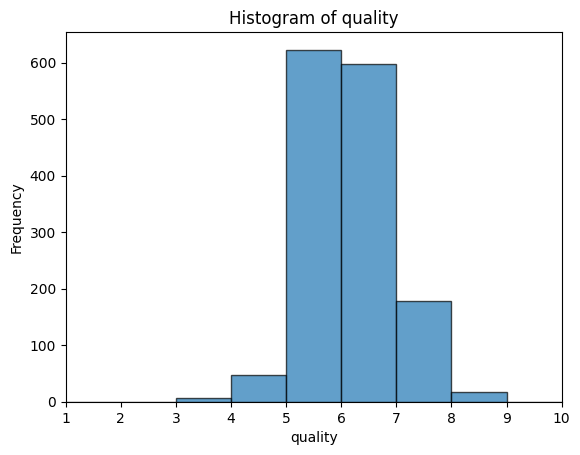

quality
5    623
6    598
7    179
4     48
8     17
3      7
Name: count, dtype: int64


In [10]:
# for testing reasons: create a dataset without outliers
raw_data_no_outliers = raw_data_red[~iqr_outlier_mask.any(axis=1)]

# plot a histogram
plt.hist(raw_data_no_outliers['quality'], bins=range(0, 12), edgecolor='k', alpha=0.7)
plt.xlabel('quality')
plt.ylabel('Frequency')
plt.title('Histogram of quality')
plt.xlim(1, 10)
plt.show()

# show the number of entries for each value
value_counts = raw_data_no_outliers['quality'].value_counts()
print(value_counts)

Eliminating the outliers has an impact on one of the less common classes (quality = 3), resulting in a reduction of 30% in data points. This suggests a potential pattern, but due to the absence of domain knowledge and the assertion of the data source that the dataset is error-free, these identified 'outliers' will be retained, considering the possibility of substantial variability in the values.

To explore potential linear dependencies and gain insights into the relationships between features and the target variable, we will now generate plots of each feature against the target variable as part of our general exploratory data analysis.

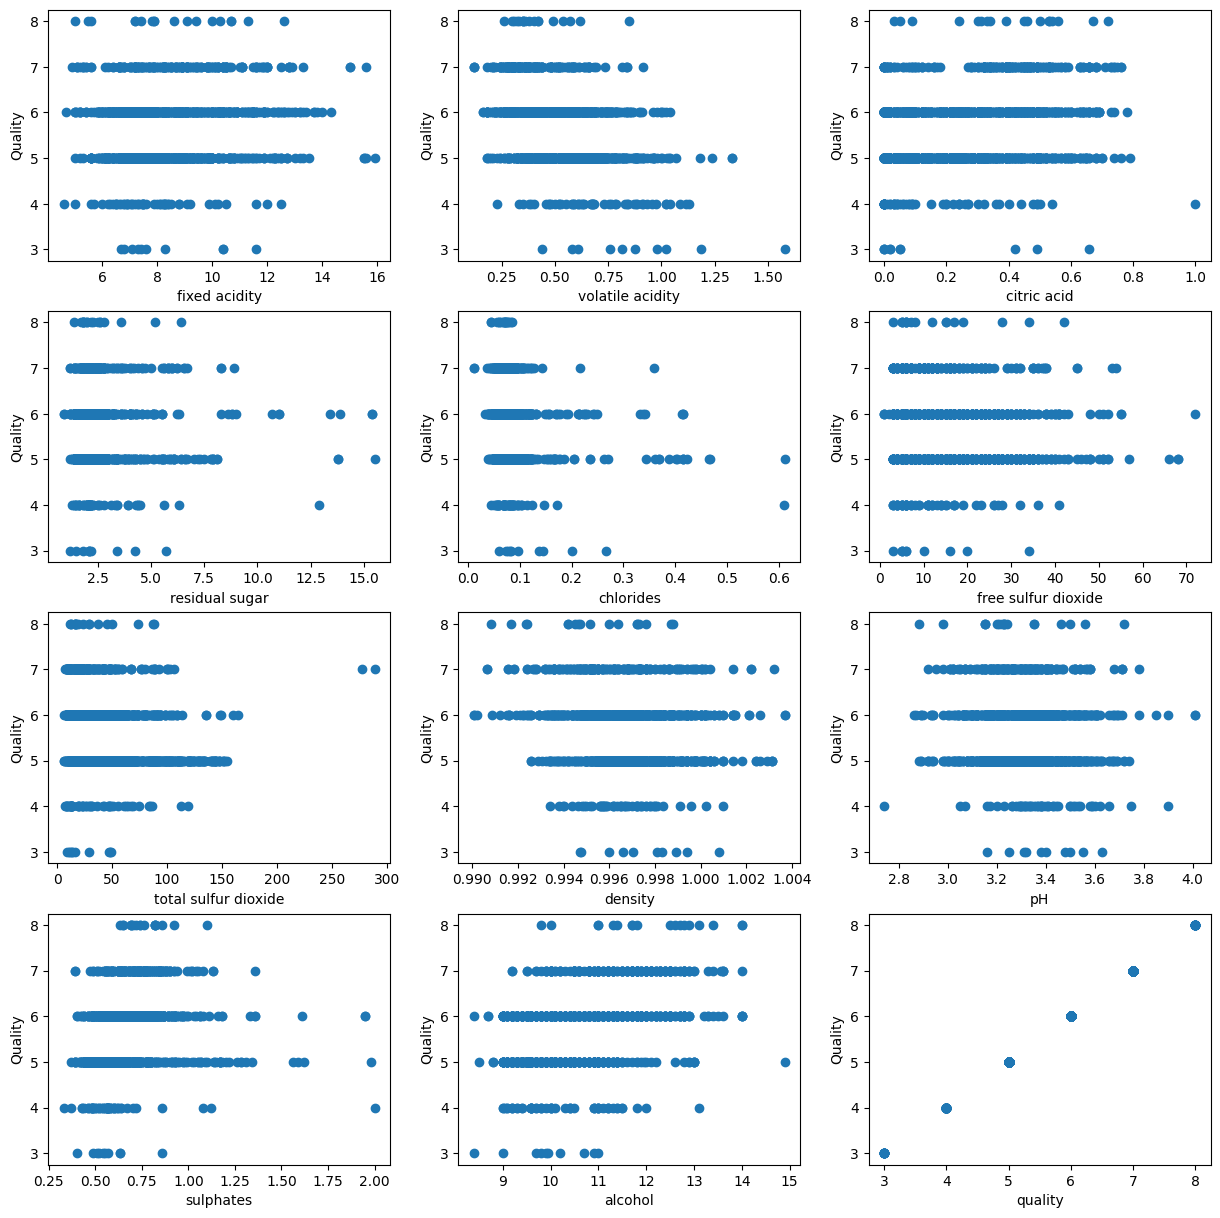

In [12]:
# create some plots to detect linear dependencies

# create a list of all columns that we could consider
#features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
features = raw_data_red.select_dtypes(include=[np.number])

# create a figure and specify its size
fig = plt.figure(figsize=(15,15))

# go through all features 
figure_index = 1
for feature in features:
    # add a subplot to the figure
    axs = fig.add_subplot(4,3,figure_index)
    
    # plot the feature as x
    axs.scatter(raw_data_red[feature], raw_data_red['quality'])
    
    # set the axis labels of the current subplot
    axs.set_xlabel(feature)
    axs.set_ylabel('Quality')
        
    # increase the figure index
    figure_index+=1

    
# show the plot
plt.show()

No evident linear dependencies are apparent; however, a subtle positive linear association appears observable between quality and alcohol, while a slight negative linear relationship seems to exist between quality and volatile acidity.

Because of the absence of clear results in the initial exploration, we will further investigate potential patterns by examining boxplots for each feature at every quality level.

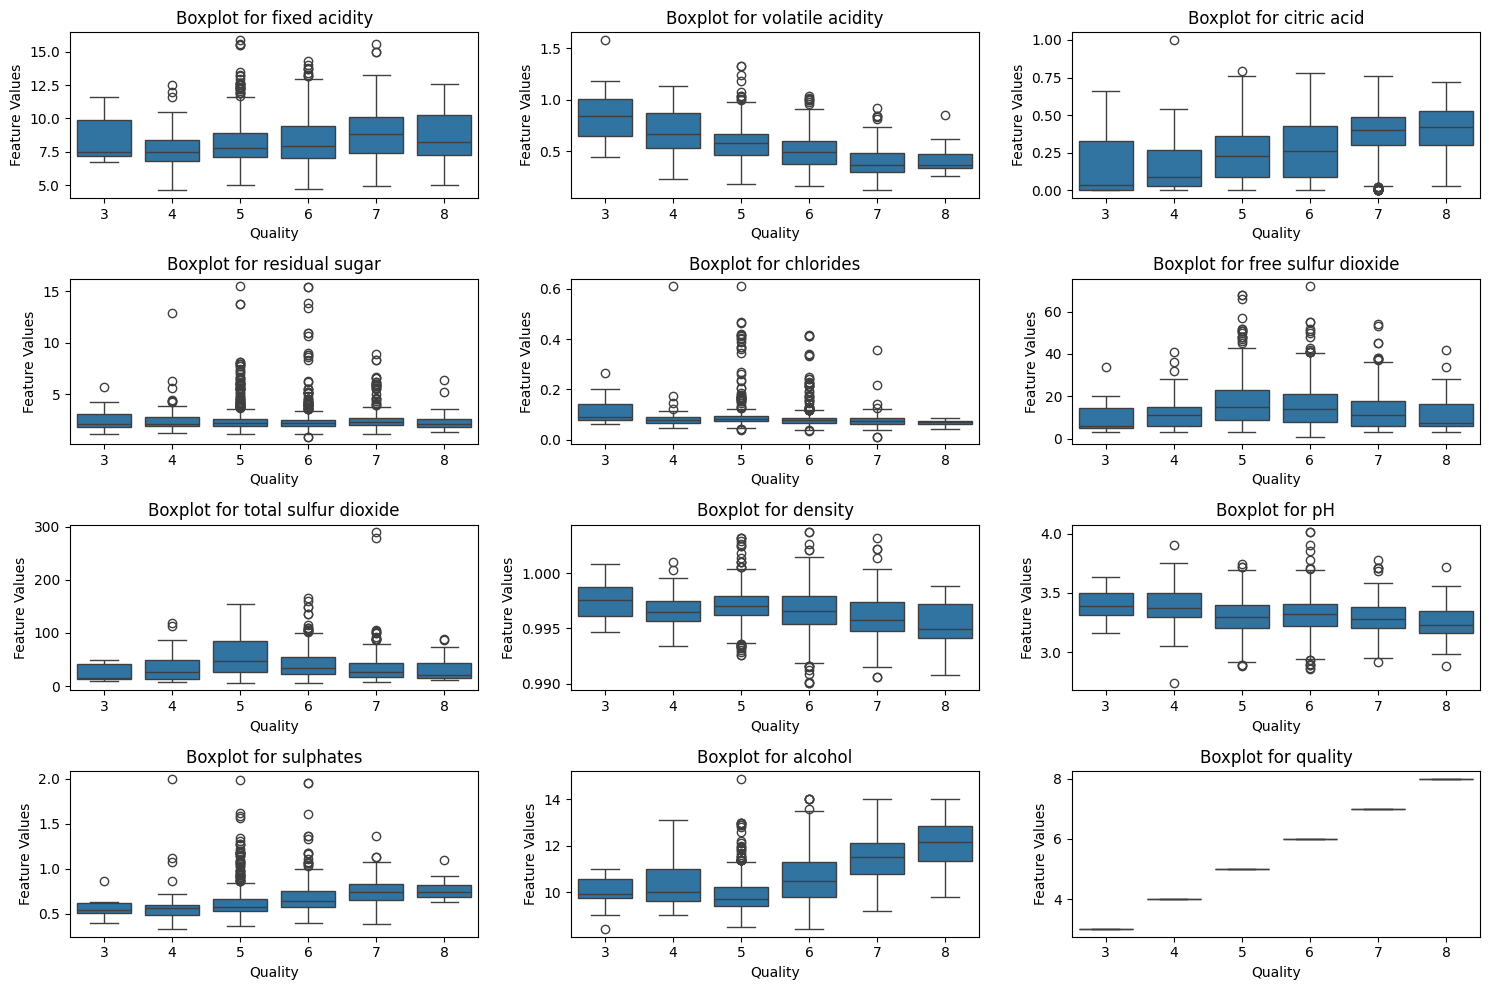

In [13]:
# find the boxplots of the features depending on the quality to see if there is a pattern 

def boxplot_dependencies(data, title): 
    
    # get numeric columns
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Set up subplots for each numeric feature in a 4x3 grid
    num_rows = 4
    num_cols = 3
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))
    plt.title(title)
    
    # Flatten the axes for easy iteration
    axes = axes.flatten()
    
    # Create boxplots for each numeric feature using seaborn
    for i, feature in enumerate(numeric_columns):
        sns.boxplot(x='quality', y=feature, data=data, ax=axes[i])
        axes[i].set_title(f'Boxplot for {feature}')
    
    # Remove empty subplots if there are fewer features than subplots
    for j in range(num_rows * num_cols):
        if j >= len(numeric_columns):
            fig.delaxes(axes[j])
    
    # Set common labels and title for all subplots
    for ax in axes:
        ax.set_xlabel('Quality')
        ax.set_ylabel('Feature Values')
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

boxplot_dependencies(raw_data_red, "Red")

The slight positive correlation of alcohol is confirmed, and the same holds for fixed acidity, albeit very slightly negative. However, there are no significant additional patterns observed, except perhaps for pH, which exhibits a slight negative correlation.

Now, let's turn our attention to the exploration of the correlation matrix. Specifically, we are interested in the last row/column, as our focus is on examining the correlation of features with the target variable, quality.

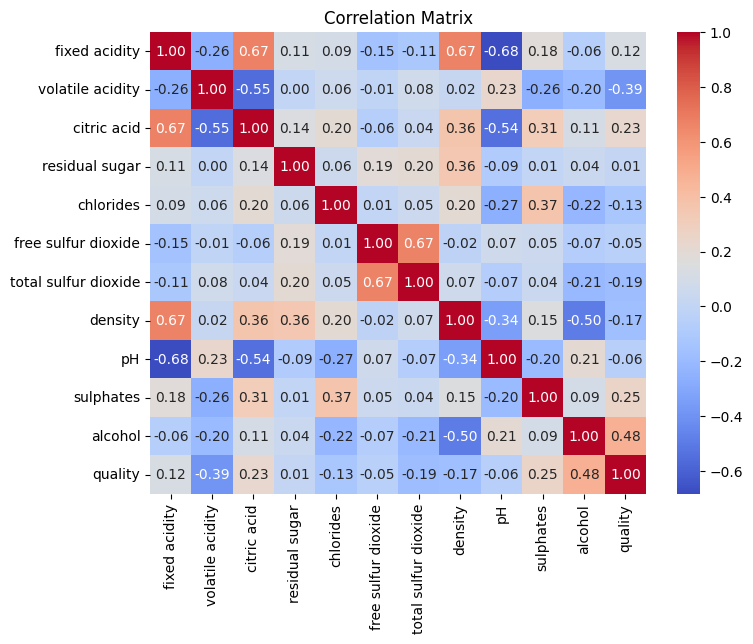

In [15]:
# in addition: explore the linear correlatin matrix

def corr_matrix(data): 
    
    # create correlation matrix
    correlation_matrix = data.corr()
    
    # create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    
    # plot the heatmap
    plt.title("Correlation Matrix")
    plt.show()

corr_matrix(raw_data_red)

Given that our goal is to predict the quality feature, it's crucial to scrutinize the last column or row of the correlation matrix. However, as observed in the preceding plots, there is no substantial dependency between most specific features and quality. The only three features displaying a slightly higher correlation are volatile acidity (-0.39), sulphates (+0.25), and alcohol (+0.48).

Considering the insights from these graphs, engaging in feature selection engineering could prove valuable. This is particularly relevant because, as indicated by the earlier plots, there is no prominent linear relationship between individual features and quality. Therefore, identifying and retaining only the most influential features could enhance the predictive capability of our model.

In preparation for model selection and hyperparameter tuning, the dataset is divided into training and testing sets. The target variable, 'quality,' is separated from the attributes. The split is performed using the train_test_split function, resulting in data_train, data_test, target_train, and target_test, with a test size of 20% and stratification based on the 'quality' variable for balanced representation across the datasets.

In [16]:
# get the data ready for model selection and hyperparameter tuning

# create test- and train- (later used in cross-validation for creating a train- and val- dataset) dataset

# split attributes and label                                                      
wine_target = raw_data_red['quality']
wine_data = raw_data_red.drop(columns='quality')

# create split
data_train, data_test, target_train, target_test = train_test_split(wine_data, wine_target, test_size=0.2, random_state = 42, stratify=wine_target)

We define pipelines for various regression models, incorporating preprocessing steps such as z-transformation using StandardScaler and oversampling using RandomOverSampler to address potential class imbalances. The pipelines are set up for k-Nearest Neighbors Regression (training_pipeline_knnreg), Decision Tree Regression (training_pipeline_dtreg), Linear Regression (training_pipeline_linreg), Ridge Regression (training_pipeline_ridgereg), and Multi-layer Perceptron Regression (training_pipeline_mlpreg). These pipelines encapsulate the entire process from data preprocessing to model training. The commented-out section provides an example of how to check the effects of the pipeline on the training data.
The choice of regression models in the pipelines reflects a consideration of their specific characteristics and suitability for the task at hand.
k-Nearest Neighbors Regression is chosen for its simplicity and flexibility.
Decision Tree Regression is selected for its ability to capture non-linear relationships, providing a comprehensive understanding of feature-target interactions.
Linear Regression offers interpretability and efficiency, making it suitable for cases where the relationship between features and target is relatively linear.
Ridge Regression is employed to address potential multicollinearity issues, enhancing model stability. 
Multi-layer Perceptron Regression, a form of neural network, is included for its capacity to capture complex patterns and relationships.

Disclaimer: The provided code establishes multiple regression pipelines, each dedicated to analyzing the optimal parameters for individual regression models. This approach, while beneficial for an in-depth assessment of algorithm-specific performance and parameter tuning, may not be the most efficient means of identifying the overall best model. 




In [19]:
# define pipeline for training and prediction

# define numerical columns
numeric_columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

# preprocessor - scale - StandardScaler (z-Transformation)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
    ])

# pipeline - balance - RandomOverSampler (generates synthetic samples randomly) and estimator
training_pipeline_knnreg = Pipeline([
    ('preprocessing', preprocessor),
    ('balancer', RandomOverSampler()),
    ('estimator', KNeighborsRegressor())
])

training_pipeline_dtreg = Pipeline([
    ('preprocessing', preprocessor),
    ('balancer', RandomOverSampler()),
    ('estimator', DecisionTreeRegressor())
])

training_pipeline_linreg = Pipeline([
    ('preprocessing', preprocessor),
    ('balancer', RandomOverSampler()),
    ('estimator', LinearRegression())
])

training_pipeline_ridgereg = Pipeline([
    ('preprocessing', preprocessor),
    ('balancer', RandomOverSampler()),
    ('estimator', Ridge())
])

training_pipeline_mlpreg = Pipeline([
    ('preprocessing', preprocessor),
    ('balancer', RandomOverSampler()),
    ('estimator', MLPRegressor())
])

'''
# check functions of pipeline
print(data_train.shape)

# get the balanced data
oversampled_data, oversampled_target = training_pipeline_knnreg.named_steps['balancer'].fit_resample(data_train, target_train)

# fit and transform the transformers in the pipeline on the training data
oversampled_data = training_pipeline_knnreg.named_steps['preprocessing'].fit_transform(oversampled_data)

# check the shape of the new data
print("Oversampled Data Shape:", oversampled_data.shape)
print("Oversampled Target Shape:", oversampled_target.shape)

# Display the head of the oversampled data
print("Head of Oversampled Data:")
display(pd.DataFrame(oversampled_data).head())

# Display the value counts of the oversampled target
print("Oversampled Target Value Counts:")
print(oversampled_target.value_counts())
'''

'\n# check functions of pipeline\nprint(data_train.shape)\n\n# get the balanced data\noversampled_data, oversampled_target = training_pipeline_knnreg.named_steps[\'balancer\'].fit_resample(data_train, target_train)\n\n# fit and transform the transformers in the pipeline on the training data\noversampled_data = training_pipeline_knnreg.named_steps[\'preprocessing\'].fit_transform(oversampled_data)\n\n# check the shape of the new data\nprint("Oversampled Data Shape:", oversampled_data.shape)\nprint("Oversampled Target Shape:", oversampled_target.shape)\n\n# Display the head of the oversampled data\nprint("Head of Oversampled Data:")\ndisplay(pd.DataFrame(oversampled_data).head())\n\n# Display the value counts of the oversampled target\nprint("Oversampled Target Value Counts:")\nprint(oversampled_target.value_counts())\n'

The parameter distributions for randomized testing are meticulously defined to conduct a comprehensive exploration of hyperparameters for each regression model.

In [20]:
# define parameter distribution for Randomized Testing

param_dist_knnreg = {
    'estimator__n_neighbors': range(1, 21),  # Number of neighbors
    'estimator__weights': ['uniform', 'distance'],  # Weighting scheme
    'estimator__p': [1, 2],  # Power parameter for Minkowski distance
    'estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
    'estimator__leaf_size': range(10, 41),  # Leaf size for tree-based algorithms
    'estimator__metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
}


param_dist_dtreg = {
    'estimator__max_depth': range(2, 21),  # Maximum depth of the tree
    'estimator__min_samples_split': range(2, 11),  # Minimum samples required to split an internal node
    'estimator__min_samples_leaf': range(1, 11),  # Minimum samples required at a leaf node
    'estimator__max_features': ['sqrt', 'log2', None],  # The number of features to consider when looking for the best split
    'estimator__splitter': ['best', 'random'],  # The strategy used to choose the split at each node
    'estimator__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],  # The function to measure the quality of a split
}

param_dist_linear = {
    'estimator__fit_intercept': [True, False],
}

param_dist_ridge = {
    'estimator__alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'estimator__fit_intercept': [True, False],
    'estimator__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
}

param_dist_mlp = {
    'estimator__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'estimator__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'estimator__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'estimator__learning_rate': ['constant', 'invscaling', 'adaptive'],
}

Advancing, the root mean squared error (RMSE) is utilized as a scoring metric, with lower values indicating better model performance. A Stratified K-Fold cross-validation with 10 folds and shuffling is employed to robustly evaluate the models. Randomized search is performed for hyperparameter tuning on each regression model. The best hyperparameter configurations are determined by searching through the predefined parameter spaces. The mean RMSE for each model is calculated based on cross-validation results, providing an insight into their predictive performance on the training dataset.

In [36]:
# Define the MSE scorer
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Define the folds for cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the RandomizedSearchCV instance for KNeighborsRegression
knnreg_randomized_search_estimator = RandomizedSearchCV(training_pipeline_knnreg, param_distributions=param_dist_knnreg, scoring=mse_scorer, cv=cv, random_state = 42)
knnreg_mse_best = cross_val_score(knnreg_randomized_search_estimator, data_train, target_train, cv=cv, scoring=mse_scorer, n_jobs=-1)

# Calculate the mean RMSE
mean_mse = -knnreg_mse_best.mean()
print("Mean RMSE for best KNeighborsRegression:", sqrt(mean_mse))


# Create the RandomizedSearchCV instance for DecisionTreRegression
dtreg_randomized_search_estimator = RandomizedSearchCV(training_pipeline_dtreg, param_distributions=param_dist_dtreg, scoring=mse_scorer, cv=cv, random_state = 42)
dtreg_mse_best = cross_val_score(dtreg_randomized_search_estimator, data_train, target_train, cv=cv, scoring=mse_scorer, n_jobs=-1)

# Calculate the mean RMSE
mean_mse = -dtreg_mse_best.mean()
print("Mean RMSE for best DecisionTreeRegression:", sqrt(mean_mse))


# Create the RandomizedSearchCV instance for LinearRegression
linreg_randomized_search_estimator = RandomizedSearchCV(training_pipeline_linreg, param_distributions=param_dist_linear, scoring=mse_scorer, cv=cv, random_state = 42)
linreg_mse_best = cross_val_score(linreg_randomized_search_estimator, data_train, target_train, cv=cv, scoring=mse_scorer, n_jobs=-1)

# Calculate the mean RMSE
mean_mse = -linreg_mse_best.mean()
print("Mean RMSE for best LinearRegression:", sqrt(mean_mse))


# Create the RandomizedSearchCV instance for RidgeRegression
ridgereg_randomized_search_estimator = RandomizedSearchCV(training_pipeline_ridgereg, param_distributions=param_dist_ridge, scoring=mse_scorer, cv=cv, random_state = 42)
ridgereg_mse_best = cross_val_score(ridgereg_randomized_search_estimator, data_train, target_train, cv=cv, scoring=mse_scorer, n_jobs=-1)

# Calculate the mean RMSE
mean_mse = -ridgereg_mse_best.mean()
print("Mean RMSE for best RidgeRegression:", sqrt(mean_mse))


# Create the RandomizedSearchCV instance for MLPRegression
mlpreg_randomized_search_estimator = RandomizedSearchCV(training_pipeline_mlpreg, param_distributions=param_dist_mlp, scoring=mse_scorer, cv=cv, random_state = 42)
mlpreg_mse_best = cross_val_score(mlpreg_randomized_search_estimator, data_train, target_train, cv=cv, scoring=mse_scorer, n_jobs=-1)

# Calculate the mean RMSE
mean_mse = -mlpreg_mse_best.mean()
print("Mean RMSE for best MLPRegression:", sqrt(mean_mse))

Mean RMSE for best KNeighborsRegression: 0.7633047315828828
Mean RMSE for best DecisionTreeRegression: 0.8142897236549825
Mean RMSE for best LinearRegression: 0.917605156153055
Mean RMSE for best RidgeRegression: 0.9144932599093435
Mean RMSE for best MLPRegression: 0.7518278272340072


The evaluation of the models based on the mean root mean squared error (RMSE) highlights the superior performance of the Multi-layer Perceptron model, which achieved the lowest RMSE of 0.752. The K-Neighbors Regression also demonstrated competitive performance with an RMSE of 0.763. In contrast, Decision Tree Regression exhibited a slightly higher RMSE of 0.814, while both Linear Regression and Ridge Regression models had comparable RMSE values around 0.918 and 0.914, respectively. Overall, the K-Neighbors Regression and Multi-layer Perceptron Regression models emerge as strong candidates for predicting wine quality in this dataset.
However, to ensure the reliability and generalizability of these findings, it is crucial to evaluate the selected models on the test dataset, confirming their predictive capabilities beyond the training data. To do so, we evaluate the best-performing model variants, identified through the randomized search, on the test dataset. For each model, it displays the optimal hyperparameters, followed by the mean absolute error (MAE), root mean squared error (RMSE), and R-squared (R^2) values as metrics for assessing their predictive accuracy on the test set. This comprehensive evaluation provides a final assessment of the models' performance and their ability to generalize beyond the training data.a.

In [22]:
# take a look at the parameters for the best model-variants
# and evaluate the model on the test set

print('===KNeighborsRegression===')
knnreg_randomized_search_estimator.fit(data_train, target_train)
display(knnreg_randomized_search_estimator.best_params_)
predictions = knnreg_randomized_search_estimator.predict(data_test)
mae = mean_absolute_error(target_test, predictions)
mse = mean_squared_error(target_test, predictions)
r2 = r2_score(target_test, predictions)
print("MAE: {}".format(mae))
print("RMSE: {}".format(sqrt(mse)))
print("R^2: {}".format(r2))

print('\n\n===DecisionTreeRegression===')
dtreg_randomized_search_estimator.fit(data_train, target_train)
display(dtreg_randomized_search_estimator.best_params_)
predictions = dtreg_randomized_search_estimator.predict(data_test)
mae = mean_absolute_error(target_test, predictions)
mse = mean_squared_error(target_test, predictions)
r2 = r2_score(target_test, predictions)
print("MAE: {}".format(mae))
print("RMSE: {}".format(sqrt(mse)))
print("R^2: {}".format(r2))

print('\n\n===LinearRegression===')
linreg_randomized_search_estimator.fit(data_train, target_train)
display(linreg_randomized_search_estimator.best_params_)
predictions = linreg_randomized_search_estimator.predict(data_test)
mae = mean_absolute_error(target_test, predictions)
mse = mean_squared_error(target_test, predictions)
r2 = r2_score(target_test, predictions)
print("MAE: {}".format(mae))
print("RMSE: {}".format(sqrt(mse)))
print("R^2: {}".format(r2))

print('\n\n===RidgeRegression===')
ridgereg_randomized_search_estimator.fit(data_train, target_train)
display(ridgereg_randomized_search_estimator.best_params_)
predictions = ridgereg_randomized_search_estimator.predict(data_test)
mae = mean_absolute_error(target_test, predictions)
mse = mean_squared_error(target_test, predictions)
r2 = r2_score(target_test, predictions)
print("MAE: {}".format(mae))
print("RMSE: {}".format(sqrt(mse)))
print("R^2: {}".format(r2))

print('\n\n===MLPRegression===')
mlpreg_randomized_search_estimator.fit(data_train, target_train)
display(mlpreg_randomized_search_estimator.best_params_)
predictions = mlpreg_randomized_search_estimator.predict(data_test)
mae = mean_absolute_error(target_test, predictions)

r2 = r2_score(target_test, predictions)
print("MAE: {}".format(mae))
print("RMSE: {}".format(sqrt(mse)))
print("R^2: {}".format(r2))

===KNeighborsRegression===


{'estimator__weights': 'distance',
 'estimator__p': 1,
 'estimator__n_neighbors': 7,
 'estimator__metric': 'euclidean',
 'estimator__leaf_size': 36,
 'estimator__algorithm': 'auto'}

MAE: 0.49454598549109097
RMSE: 0.7610047683716851
R^2: 0.1025072103879342


===DecisionTreeRegression===


{'estimator__splitter': 'best',
 'estimator__min_samples_split': 10,
 'estimator__min_samples_leaf': 10,
 'estimator__max_features': 'log2',
 'estimator__max_depth': 15,
 'estimator__criterion': 'poisson'}

MAE: 0.6329989785018995
RMSE: 0.8205557699740699
R^2: -0.04345186475731633


===LinearRegression===


{'estimator__fit_intercept': True}

MAE: 0.7163140667006397
RMSE: 0.9115422149612424
R^2: -0.28768543902203914


===RidgeRegression===


{'estimator__solver': 'lsqr',
 'estimator__fit_intercept': True,
 'estimator__alpha': 2.0}

MAE: 0.7174965790412149
RMSE: 0.9095952453330761
R^2: -0.282190560234457


===MLPRegression===


{'estimator__learning_rate': 'adaptive',
 'estimator__hidden_layer_sizes': (100, 50),
 'estimator__alpha': 0.01,
 'estimator__activation': 'relu'}

MAE: 0.5491710184795698
RMSE: 0.9095952453330761
R^2: 0.176839545713244


The assessment of models based on the mean root mean squared error (RMSE) for this dataset indicates noteworthy distinctions in predictive performance. K-Neighbors Regression, characterized by optimal hyperparameters {'estimator__weights': 'distance', 'estimator__p': 1, 'estimator__n_neighbors': 7, 'estimator__metric': 'euclidean', 'estimator__leaf_size': 36, 'estimator__algorithm': 'auto'}, continues to excel with the lowest RMSE of 0.761, reaffirming its robust predictive capabilities. In contrast, the Multi-layer Perceptron Regression model, despite demonstrating competitive performance initially, showcases an increased RMSE of 0.910 in this evaluation. Despite the increased RMSE for Multi-layer Perceptron Regression (MLP) in this evaluation, it's worth noting that the Mean Absolute Error (MAE) for MLP remains lower than that of Decision Tree Regression (DTreg). This suggests that, while MLP may face challenges in predicting the exact values accurately (as indicated by the higher RMSE), it still outperforms DTreg in terms of the average absolute difference between predicted and actual values. This underscores the nuanced nature of model evaluation, where different metrics provide distinct insights into performance, and the choice of the most relevant metric depends on the specific goals of the prediction task.

Given our previous discussions on non-relevant features observed in the graphs, our plan is to delve into a thorough exploration using the F-Score metric. Through this exploration, our aim is to identify and isolate the statistically significant features. Subsequently, we intend to exclusively utilize these features in the model-building process, with the hope of enhancing generalization capabilities.

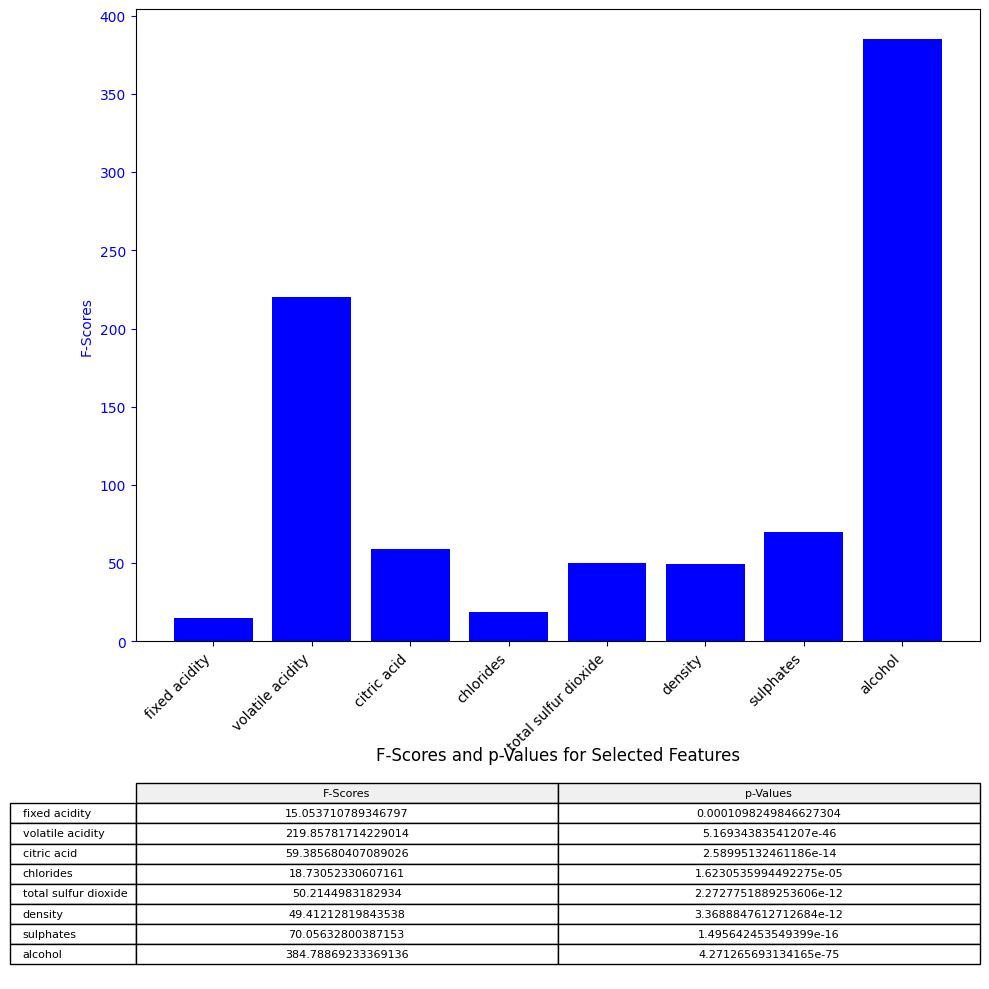

In [35]:
# Feature Engineering

# Store original feature names
original_feature_names = data_train.columns.tolist()

# Identify numeric columns
numeric_columns = data_train.select_dtypes(include=['number']).columns.tolist()

# Create a ColumnTransformer to scale numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
    ])

# Create a pipeline with the ColumnTransformer and SelectFwe
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectFwe(score_func=f_regression, alpha=0.01))
])

# Fit and transform the data
X_selected = pipeline.fit_transform(data_train, target_train)

# Get selected feature indices
selected_indices = pipeline.named_steps['selector'].get_support(indices=True)

# Get F-scores and p-values for all features
f_scores, p_values = f_regression(data_train, target_train)

# Extract F-scores and p-values for selected features
selected_f_scores = f_scores[selected_indices]
selected_p_values = p_values[selected_indices]

# Get corresponding feature names after preprocessing
selected_feature_names = [original_feature_names[i] for i in selected_indices]

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

# Bar plot for F-scores
ax1.bar(selected_feature_names, selected_f_scores, label='F-Scores', color='b')
ax1.set_ylabel('F-Scores', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xticklabels(selected_feature_names, rotation=45, ha='right')

# Table
table_data = pd.DataFrame({'F-Scores': selected_f_scores, 'p-Values': selected_p_values}, index=selected_feature_names)
table = ax2.table(cellText=table_data.values, colLabels=table_data.columns, rowLabels=table_data.index, loc='center', cellLoc='center', colColours=['#f0f0f0']*len(table_data.columns))
table.auto_set_font_size(False)
table.set_fontsize(8)

ax2.axis('off')  # Turn off the axis for the second subplot

fig.tight_layout()
plt.title('F-Scores and p-Values for Selected Features')
plt.show()

The SelectFwe method is employed to select statistically significant features based on F-scores and a significance level (alpha) of 0.01. The choice of an alpha value of 0.01 for the SelectFwe method is driven by the desire to control the familywise error rate, ensuring a stringent criterion for feature selection and reducing the likelihood of false positives in identifying statistically significant features. The selected features are 'fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'density', 'sulphates', and 'alcohol'.

Now we need to compute again the optimal models and reiterate the above steps. 

In [37]:
# define pipeline for training and prediction

# define numerical columns // type is already transformed via LabelEncoder
numeric_columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'density', 'alcohol', 'type']


# preprocessor - scale - StandardScaler (z-Transformation) - label - OneHotEncoder (binary) // as there is no passthrough statement all other features are dropped
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns)
    ])


# Create the RandomizedSearchCV instance for KNeighborsRegression
knnreg_randomized_search_estimator = RandomizedSearchCV(training_pipeline_knnreg, param_distributions=param_dist_knnreg, scoring=mse_scorer, cv=cv, random_state = 42)
knnreg_mse_best = cross_val_score(knnreg_randomized_search_estimator, data_train, target_train, cv=cv, scoring=mse_scorer, n_jobs=-1)

# Calculate the mean RMSE
mean_mse = -knnreg_mse_best.mean()
print("Mean RMSE for best KNeighborsRegression:", sqrt(mean_mse))


# Create the RandomizedSearchCV instance for DecisionTreRegression
dtreg_randomized_search_estimator = RandomizedSearchCV(training_pipeline_dtreg, param_distributions=param_dist_dtreg, scoring=mse_scorer, cv=cv, random_state = 42)
dtreg_mse_best = cross_val_score(dtreg_randomized_search_estimator, data_train, target_train, cv=cv, scoring=mse_scorer, n_jobs=-1)

# Calculate the mean RMSE
mean_mse = -dtreg_mse_best.mean()
print("Mean RMSE for best DecisionTreeRegression:", sqrt(mean_mse))


# Create the RandomizedSearchCV instance for LinearRegression
linreg_randomized_search_estimator = RandomizedSearchCV(training_pipeline_linreg, param_distributions=param_dist_linear, scoring=mse_scorer, cv=cv, random_state = 42)
linreg_mse_best = cross_val_score(linreg_randomized_search_estimator, data_train, target_train, cv=cv, scoring=mse_scorer, n_jobs=-1)

# Calculate the mean RMSE
mean_mse = -linreg_mse_best.mean()
print("Mean RMSE for best LinearRegression:", sqrt(mean_mse))


# Create the RandomizedSearchCV instance for RidgeRegression
ridgereg_randomized_search_estimator = RandomizedSearchCV(training_pipeline_ridgereg, param_distributions=param_dist_ridge, scoring=mse_scorer, cv=cv, random_state = 42)
ridgereg_mse_best = cross_val_score(ridgereg_randomized_search_estimator, data_train, target_train, cv=cv, scoring=mse_scorer, n_jobs=-1)

# Calculate the mean RMSE
mean_mse = -ridgereg_mse_best.mean()
print("Mean RMSE for best RidgeRegression:", sqrt(mean_mse))


# Create the RandomizedSearchCV instance for MLPRegression
mlpreg_randomized_search_estimator = RandomizedSearchCV(training_pipeline_mlpreg, param_distributions=param_dist_mlp, scoring=mse_scorer, cv=cv, random_state = 42)
mlpreg_mse_best = cross_val_score(mlpreg_randomized_search_estimator, data_train, target_train, cv=cv, scoring=mse_scorer, n_jobs=-1)

# Calculate the mean RMSE
mean_mse = -mlpreg_mse_best.mean()
print("Mean RMSE for best MLPRegression:", sqrt(mean_mse))

Mean RMSE for best KNeighborsRegression: 0.7594399574552124
Mean RMSE for best DecisionTreeRegression: 0.822103247729404
Mean RMSE for best LinearRegression: 0.9134455413719627
Mean RMSE for best RidgeRegression: 0.9191145335106389
Mean RMSE for best MLPRegression: 0.7766191044930612


In [26]:
# take a look at the parameters for the best model-variants
# and evaluate the model on the test set

print('===KNeighborsRegression===')
knnreg_randomized_search_estimator.fit(data_train, target_train)
display(knnreg_randomized_search_estimator.best_params_)
knr_predictions = knnreg_randomized_search_estimator.predict(data_test)
mae = mean_absolute_error(target_test, knr_predictions)
mse = mean_squared_error(target_test, knr_predictions)
r2 = r2_score(target_test, knr_predictions)
print("MAE: {}".format(mae))
print("RMSE: {}".format(sqrt(mse)))
print("R^2: {}".format(r2))

print('\n\n===DecisionTreeRegression===')
dtreg_randomized_search_estimator.fit(data_train, target_train)
display(dtreg_randomized_search_estimator.best_params_)
predictions = dtreg_randomized_search_estimator.predict(data_test)
mae = mean_absolute_error(target_test, predictions)
mse = mean_squared_error(target_test, predictions)
r2 = r2_score(target_test, predictions)
print("MAE: {}".format(mae))
print("RMSE: {}".format(sqrt(mse)))
print("R^2: {}".format(r2))

print('\n\n===LinearRegression===')
linreg_randomized_search_estimator.fit(data_train, target_train)
display(linreg_randomized_search_estimator.best_params_)
predictions = linreg_randomized_search_estimator.predict(data_test)
mae = mean_absolute_error(target_test, predictions)
mse = mean_squared_error(target_test, predictions)
r2 = r2_score(target_test, predictions)
print("MAE: {}".format(mae))
print("RMSE: {}".format(sqrt(mse)))
print("R^2: {}".format(r2))

print('\n\n===RidgeRegression===')
ridgereg_randomized_search_estimator.fit(data_train, target_train)
display(ridgereg_randomized_search_estimator.best_params_)
predictions = ridgereg_randomized_search_estimator.predict(data_test)
mae = mean_absolute_error(target_test, predictions)
mse = mean_squared_error(target_test, predictions)
r2 = r2_score(target_test, predictions)
print("MAE: {}".format(mae))
print("RMSE: {}".format(sqrt(mse)))
print("R^2: {}".format(r2))

print('\n\n===MLPRegression===')
mlpreg_randomized_search_estimator.fit(data_train, target_train)
display(mlpreg_randomized_search_estimator.best_params_)
mlp_predictions = mlpreg_randomized_search_estimator.predict(data_test)
mae = mean_absolute_error(target_test, mlp_predictions)
mse = mean_squared_error(target_test, mlp_predictions)
r2 = r2_score(target_test, mlp_predictions)
print("MAE: {}".format(mae))
print("RMSE: {}".format(sqrt(mse)))
print("R^2: {}".format(r2))

===KNeighborsRegression===


{'estimator__weights': 'distance',
 'estimator__p': 1,
 'estimator__n_neighbors': 3,
 'estimator__metric': 'manhattan',
 'estimator__leaf_size': 29,
 'estimator__algorithm': 'brute'}

MAE: 0.4817650470350312
RMSE: 0.7690546701885317
R^2: 0.0834194445842329


===DecisionTreeRegression===


{'estimator__splitter': 'best',
 'estimator__min_samples_split': 8,
 'estimator__min_samples_leaf': 9,
 'estimator__max_features': 'log2',
 'estimator__max_depth': 17,
 'estimator__criterion': 'friedman_mse'}

MAE: 0.626981537237197
RMSE: 0.8349794047349628
R^2: -0.08045762589065619


===LinearRegression===


{'estimator__fit_intercept': True}

MAE: 0.7207155397194516
RMSE: 0.9107986588769212
R^2: -0.28558553444561774


===RidgeRegression===


{'estimator__solver': 'auto',
 'estimator__fit_intercept': True,
 'estimator__alpha': 5.0}

MAE: 0.7282325685903244
RMSE: 0.9221296663991218
R^2: -0.317771772766263


===MLPRegression===


{'estimator__learning_rate': 'adaptive',
 'estimator__hidden_layer_sizes': (100, 50),
 'estimator__alpha': 0.1,
 'estimator__activation': 'relu'}

MAE: 0.5217751158711893
RMSE: 0.6947560569522525
R^2: 0.2519667622737972




=== BASELINE (predict mean of quality for all training data) ===
MAE: 0.6811913604378421
MSE: 0.6453090375225954
MAPE: 12.501730681522021
RMSE: 0.8033112955278268
R^2: -5.51704448477075e-05


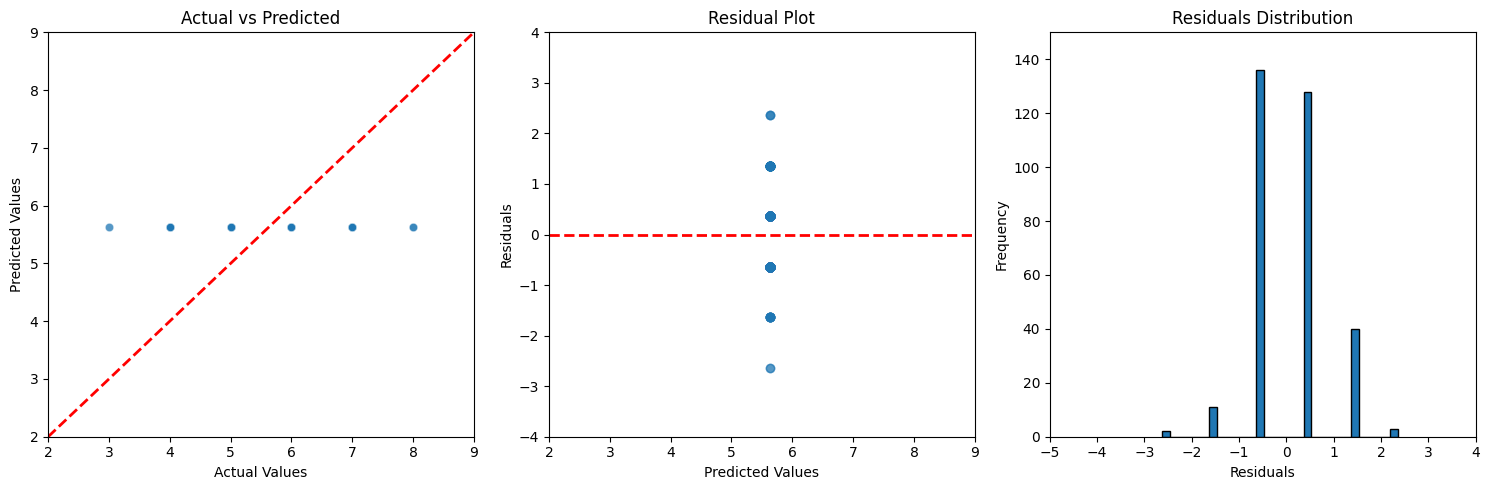



=== KNR ===
MAE: 0.4817650470350312
MSE: 0.5914450857387913
MAPE: 9.016615741549746
RMSE: 0.7690546701885317
R^2: 0.0834194445842329


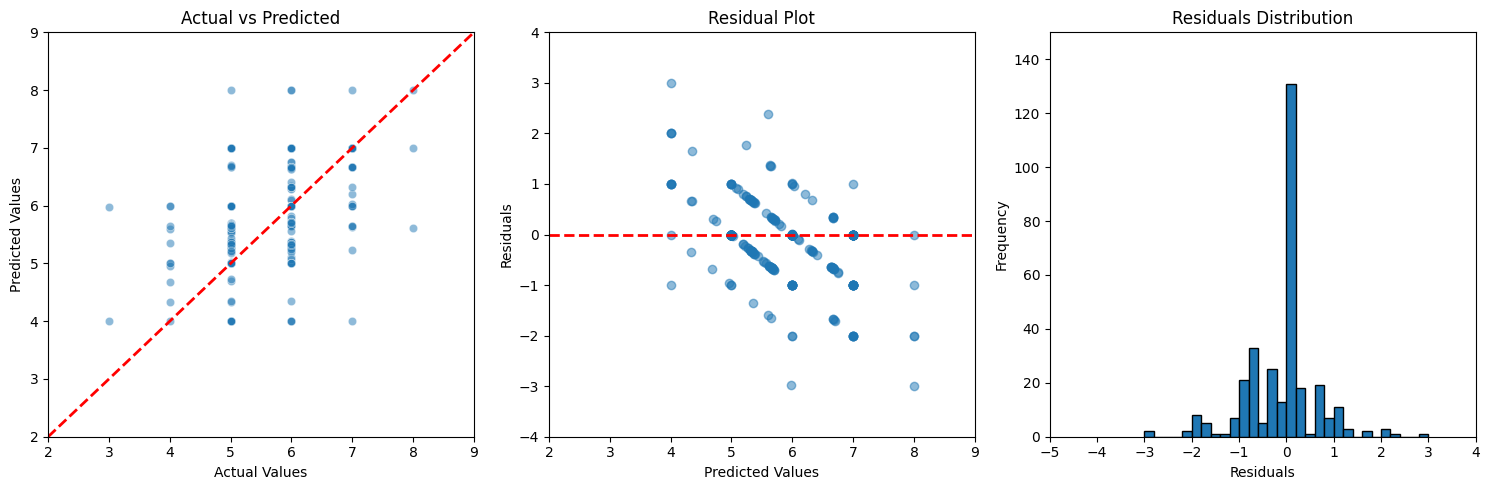



=== MLPRegression ===
MAE: 0.5217751158711893
MSE: 0.48268597867184154
MAPE: 9.667058841134866
RMSE: 0.6947560569522525
R^2: 0.2519667622737972


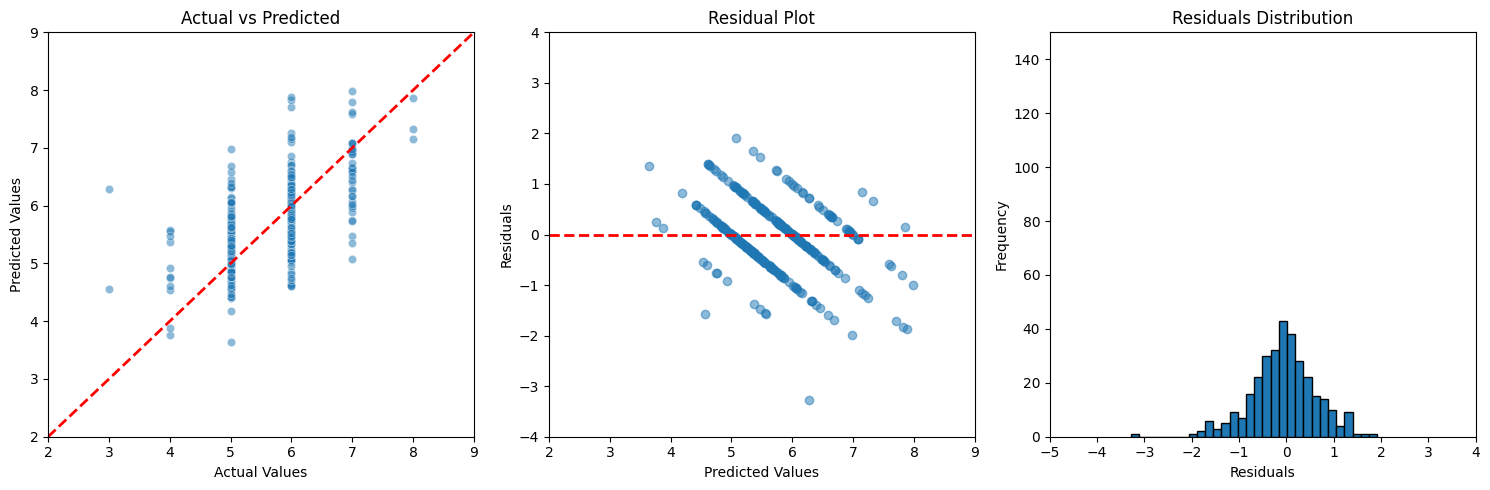

In [31]:
# analyze residuals to detect if there are systematic errors - but only examine the best two models (KNR and MLP)

# define a function that shows all the information (again) for a comprehensive view
def analyze_regression_results(y_true, y_pred):

   # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = (abs(y_true - y_pred) / y_true).mean() * 100
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Print Metrics
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'MAPE: {mape}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')

    # Plot Actual vs Predicted
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5, palette='viridis')
    plt.plot([2, 9], [2, 9], color='red', linestyle='--', linewidth=2)
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.xlim(2, 9)
    plt.ylim(2, 9)

    # Plot Residuals
    plt.subplot(1, 3, 2)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.xlim(2, 9)
    plt.ylim(-4, 4)

    

    # Plot Residuals Distribution
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.xlim(-5, 4)
    plt.ylim(0, 150)

    plt.tight_layout()
    plt.show()

print('\n\n=== BASELINE (predict mean of quality for all training data) ===')
mean_training_target = target_train.mean()
# Create a DataFrame with the mean_training_target value for each row
baseline_predictions = pd.DataFrame({'Baseline_Predictions': [mean_training_target] * len(target_test)})
baseline_predictions = baseline_predictions['Baseline_Predictions'].reset_index(drop=True)
target_test_reset = target_test.reset_index(drop=True)
analyze_regression_results(target_test_reset, baseline_predictions)

print('\n\n=== KNR ===')
analyze_regression_results(target_test, knr_predictions)

print('\n\n=== MLPRegression ===')
analyze_regression_results(target_test, mlp_predictions)

The decision to exclusively focus on K-Neighbors Regression (KNR) and Multi-layer Perceptron Regression (MLP) for further discussion is rooted in the evaluation of regression models based on the coefficient of determination (R^2) scores. Models with negative R^2 scores, such as the other regression models in consideration, indicate a poorer fit than a baseline model that simply predicts the mean of the target variable. Consequently, omitting these models from further analysis ensures a concentration on those that demonstrate at least a baseline level of predictive performance, namely KNR and MLP. This selective approach prioritizes models with the potential for meaningful insights and effective prediction in the context of the given dataset.

The process of Feature Engineering demonstrated negligible impact on the performance of the K-Neighbors Regression (KNR) model, while yielding substantial enhancements for the Multi-layer Perceptron Regression (MLP). Specifically, MLP exhibited a remarkable 25% improvement in Root Mean Squared Error (RMSE), surpassing even the performance of KNR. Although Mean Absolute Error (MAE) for MLP also improved, it still lags behind KNR. This observation is visually evident in the residuals distribution graph, where KNR displays numerous accurate predictions (residual = 0 or close to zero) but with a broader spread and more pronounced extreme outliers compared to MLP, presenting an intriguing pattern.

The improvement in MLP performance post-Feature Engineering can be attributed to the removal of statistically non-significant features. By eliminating irrelevant features, MLP was able to focus on more relevant information, enhancing its predictive capabilities. This is particularly advantageous for MLP, which relies on intricate patterns and relationships in the data. The reduced complexity facilitated by the removal of non-significant features allowed MLP to discern more meaningful patterns, leading to the observed performance improvement.

Choosing between RMSE and MAE depends on the specific goals and priorities of the wine quality prediction task. RMSE emphasizes the significance of larger errors, which could be crucial if the cost or impact of large prediction errors is substantial. On the other hand, MAE treats all errors equally, providing a more balanced evaluation. The decision between RMSE and MAE should align with the practical considerations of the application, such as the financial implications of inaccuracies or the acceptable level of variability in predictions.

We would decide on MLP as we expect that larger errors are more costly. So our preference would be MLP with the following hyperparameters: 

{'estimator__learning_rate': 'adaptive',
 'estimator__hidden_layer_sizes': (100, 50),
 'estimator__alpha': 0.1,
 'estimator__activation': 'u'}rel

The hyperparameters can be explained as follows: 

Learning Rate ('estimator__learning_rate'): The learning rate determines the step size during the optimization process. In this case, it is set to 'adaptive,' indicating that the learning rate is adjusted dynamically based on the progress of the training.

Hidden Layer Sizes ('estimator__hidden_layer_sizes'): This hyperparameter defines the architecture of the neural network, specifying the number of neurons in each hidden layer. The given tuple (100, 50) indicates two hidden layers with 100 neurons in the first layer and 50 neurons in the second layer.

Alpha ('estimator__alpha'): Alpha represents the regularization strength, controlling the impact of regularization on the neural network. A value of 0.1 suggests a moderate level of regularization to prevent overfitting.

Activation Function ('estimator__activation'): The activation function determines the output of each neuron in the network. 'ReLU' (Rectified Linear Unit) is a commonly used activation function that introduces non-linearity to the model by allowing the network to learn complex patterns.

These hyperparameters collectively influence the performance and behavior of the MLP model during training and impact its ability to capture and generalize patterns in the data. Adjusting these parameters allows fine-tuning of the model for optimal performanceey.





u'}

In [57]:
# code for prediction of our presentation-wine-sample

# as we want to go into Deployment (Deduction) we train our optimal models with all available data 
# (as the learning curve states, more data should improve model performance)

knnreg_randomized_search_estimator.fit(wine_data, wine_target)
mlpreg_randomized_search_estimator.fit(wine_data, wine_target)

# actual wine from BASF winery
colheita_red_2020 = {
    'fixed acidity': 6.0,
    'volatile acidity': np.nan,  
    'citric acid': np.nan,
    'residual sugar': np.nan,
    'chlorides': np.nan,
    'free sulfur dioxide': np.nan,
    'total sulfur dioxide': np.nan,
    'density': np.nan,
    'pH': 3.68,
    'sulphates': np.nan,
    'alcohol': 14.5,
}

# function to get mean values from the DataFrame
def get_column_means(dataframe, columns):
    return dataframe[columns].mean()

# function for mean imputation
def impute_missing_value(feature, mean_value):
    return mean_value if pd.isna(feature) else feature

# impute missing values with the mean of each column
mean_values = get_column_means(raw_data_red, colheita_red_2020.keys())

for feature in colheita_red_2020:
    colheita_red_2020[feature] = impute_missing_value(colheita_red_2020[feature], mean_values.get(feature, 0.0))

# convert the input data to a DataFrame
colheita_red_2020_df = pd.DataFrame([colheita_red_2020])

# make predictions using the trained model
knr_predicted_value = knnreg_randomized_search_estimator.predict(colheita_red_2020_df)
mlp_predicted_value = mlpreg_randomized_search_estimator.predict(colheita_red_2020_df)

# display the predicted value
print(f"KNR-Predicted Value: {knr_predicted_value}")
print(f"MLP-Predicted Value: {mlp_predicted_value}")

KNR-Predicted Value: [6.56155331]
MLP-Predicted Value: [6.99967435]
